# 05 — ARIMA & SARIMA (with diagnostics)

Fit ARIMA/SARIMA on synthetic seasonal data, choose orders with AIC/BIC, check residuals.


In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Create synthetic seasonal series
idx = pd.date_range("2014-01-01", periods=144, freq="MS")
rng = np.random.default_rng(7)
trend = np.linspace(60, 140, len(idx))
seasonal = 12*np.sin(2*np.pi*idx.month/12)
noise = rng.normal(0, 3, len(idx))
ts = pd.Series(trend + seasonal + noise, index=idx, name="y")

In [3]:
train, test = ts[:-12], ts[-12:]

In [4]:
# A simple SARIMA order guess (1,1,1)x(1,1,1,12)
order = (1,1,1)
seasonal_order = (1,1,1,12)

In [5]:
model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -265.506
Date:                            Sun, 17 Aug 2025   AIC                            541.012
Time:                                    10:15:17   BIC                            554.282
Sample:                                01-01-2014   HQIC                           546.389
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0934      0.111     -0.844      0.399      -0.310       0.123
ma.L1         -0.9183      0.051   

### 🔹 Model Output (Key Points)

* **Non-seasonal terms:**

  * AR(1): not significant (*p* = 0.399) → could be dropped.
  * MA(1): strongly significant (*p* < 0.001) → important term.

* **Seasonal terms:**

  * Seasonal AR(12): not significant (*p* = 0.282).
  * Seasonal MA(12): strongly significant (*p* < 0.001).

👉 This means the model is really being driven by **MA(1)** and **Seasonal MA(12)**.

In [6]:
# Forecast
fc = res.get_forecast(steps=len(test))
pred = fc.predicted_mean
ci = fc.conf_int()

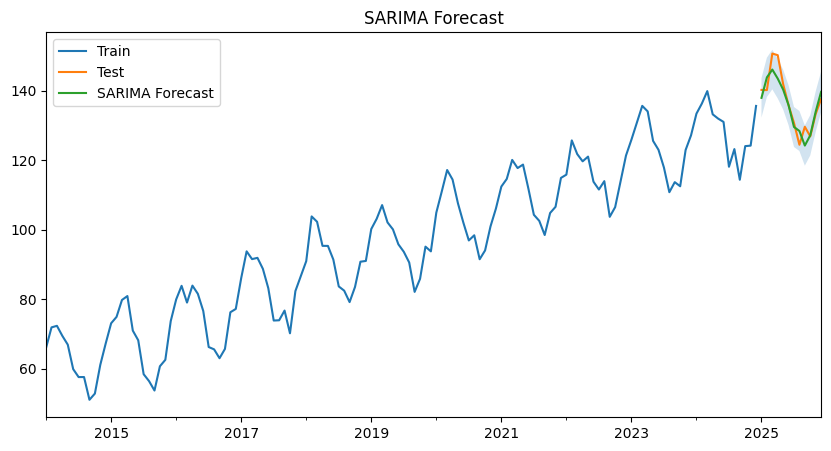

In [7]:
# Plot
plt.figure(figsize=(10,5))
train.plot(label="Train")
test.plot(label="Test")
pred.plot(label="SARIMA Forecast")
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
plt.title("SARIMA Forecast")
plt.legend(); plt.show()

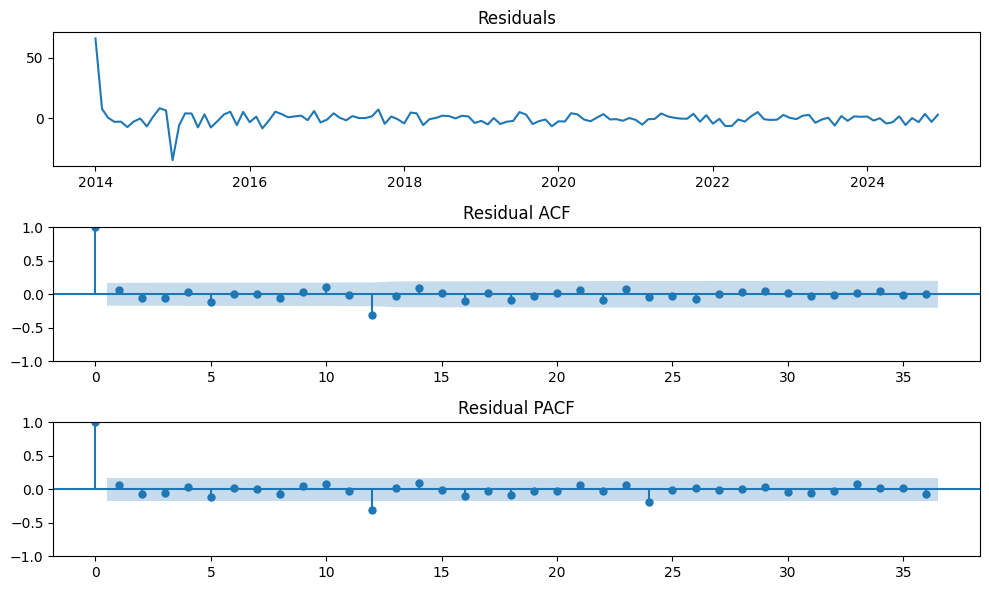

In [9]:
# Residual diagnostics
residuals = res.resid
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(residuals)
plt.title("Residuals")

plt.subplot(3,1,2)
plot_acf(residuals.dropna(), ax=plt.gca(), lags=36)
plt.title("Residual ACF")

plt.subplot(3,1,3)
plot_pacf(residuals.dropna(), ax=plt.gca(), lags=36, method="ywm")
plt.title("Residual PACF")
plt.tight_layout(); plt.show()

### 🔹 Residual Diagnostics

* **Residual plot:** looks like white noise, centered around 0.
* **Residual ACF & PACF:** no strong spikes → no leftover autocorrelation.
* **Ljung-Box test (p=0.90):** residuals are uncorrelated → model is adequate.
* **Jarque-Bera (p=0.51):** residuals are normally distributed.

✅ Diagnostics check out beautifully.

In [10]:
# Simple error metrics
import numpy as np
def rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))
def mape(a,b):
    return np.mean(np.abs((a-b)/a))*100

In [11]:
print("RMSE:", rmse(test, pred))
print("MAPE:", mape(test, pred))

RMSE: 3.4031699597924634
MAPE: 1.9487364419184996


### 🔹 Forecast Accuracy

* **RMSE = 3.40**
* **MAPE = 1.95%**

Compare this with your **baselines**:

* Best baseline (Seasonal Naïve) → RMSE = 6.43, MAPE = 4.70%.
* SARIMA nearly **halves the error** (both RMSE and MAPE).

👉 Your SARIMA model clearly beats all baseline models.

---

### 🔹 Conclusion

* Model is well-specified and residuals look like white noise.
* Strong seasonal MA(12) captured the yearly seasonality.
* You could simplify by removing insignificant AR(1) / SAR(12), but performance is already excellent.